# COMPSCI 4AL3: Deepfake Detection Project

## Group 15

This notebook provides the starting structure for our deepfake classification project using PyTorch.

**Project Goal:** Build a model to classify images as "Real" or "Fake".

## 1. Setup: Import Libraries

Import all necessary packages. We'll use `torch` and `torchvision` to build our CNN, `sklearn` for evaluation metrics, and `matplotlib` for plotting results.

In [6]:
!pip install kaggle

import copy
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from google.colab import files
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Setting global parameters
IMG_SIZE = 128
BATCH_SIZE = 32
IMAGE_SHAPE = (3, IMG_SIZE, IMG_SIZE) # PyTorch format: (Channels, Height, Width)


## 1. Importing Kaggle dataset into Colab environment

In [7]:
# 1. Create a Kaggle API token (Account Setting > API > Create New Token)
# 2. Run this cell and Upload kaggle.json into Colab or ~/.kaggle folder

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohaibahmed7","key":"da1d070a48da442d7d71abc5882a6a1d"}'}

In [8]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle


kaggle.json


In [9]:
!mkdir -p data/deepfake_images


## 2. Downloading dataset

In [10]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!unzip deepfake-and-real-images.zip -d data/deepfake_images


Streaming output truncated to the last 5000 lines.
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5499.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_55.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_550.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5500.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5501.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5502.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5503.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5504.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5505.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5506.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5507.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5508.jpg  
  inflating: data/deepfake_images/Dataset/Validation/Real/real_5

## 3. Data Loading and Preprocessing

We define a `transform` pipeline to resize, crop, convert images to Tensors, and normalize them. Then, we use `ImageFolder` to load the pre-split data and `DataLoader` to create batches.

In [11]:
# Defining paths for each split
DATA_DIR = Path("/content/data/deepfake_images/Dataset")

train_dir = DATA_DIR / 'Train'
val_dir = DATA_DIR / 'Validation'
test_dir = DATA_DIR / 'Test'

# Transforming/normalize image data (resize, convert to tensor, normalize)
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

try:
    # ImageFolder automatically infers class labels ('Fake', 'Real') from subdirectory names.
    image_datasets = {
        'train': datasets.ImageFolder(train_dir, data_transforms['train']),
        'val': datasets.ImageFolder(val_dir, data_transforms['val']),
        'test': datasets.ImageFolder(test_dir, data_transforms['test'])
    }

    # create DataLoaders to group samples from dataset into mini-batches, also shuffles data
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
        'val': DataLoader(image_datasets['val'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2),
        'test': DataLoader(image_datasets['test'], batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
    CLASS_NAMES = image_datasets['train'].classes

    print(f"Class names found: {CLASS_NAMES}")
    print(f"Dataset sizes: {dataset_sizes}")

    # Set device to GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

except FileNotFoundError:
    print("Error: Dataset directory not found.")
    print(f"Please make sure the dataset is at: {DATA_DIR}")
    print("You can download it from: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images/data")

Class names found: ['Fake', 'Real']
Dataset sizes: {'train': 140002, 'val': 39428, 'test': 10905}
Using device: cuda:0


## 4. Defining our classifier (CNN Architecture)

In [12]:
class DeepfakeClassifier(nn.Module):

    def __init__(self):
        super(DeepfakeClassifier, self).__init__()

        # Block 1: (3 x 128 x 128) -> (32 x 64 x 64)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: (32 x 64 x 64) -> (64 x 32 x 32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 3: (64 x 32 x 32) -> (128 x 16 x 16)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        # Flatten the 3D features to 1D vector (Size will be 128 * 16 * 16 = 32768)
        self.flatten = nn.Flatten()

        # Fully-connected layers
        self.fc1 = nn.Linear(in_features=128 * 16 * 16, out_features=128)

        # Output layer
        self.fc2 = nn.Linear(in_features=128, out_features=1) # We only need 1 output node for a binary classification

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x


## 5. Training the model

First, we instantiate the model, optimizer, and loss function. Then, we create a function to handle the training and validation loops (1.3).

In [14]:
# Init classifer
model = DeepfakeClassifier().to(device)

# Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss() # Binary Cross Entropy, also inherently applies a sigmoid function
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start_time = time.time()

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            print(len(dataloaders[phase]))
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.float().view(-1, 1).to(device)

                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    preds = (torch.sigmoid(outputs) > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model)
    return model, history


In [ ]:
EPOCHS = 10

if 'dataloaders' in locals():
    model, history = train_model(model, criterion, optimizer, num_epochs=EPOCHS)
else:
    print("Skipping training because data was not loaded.")

Epoch 1/10
----------
4376
train Loss: 0.2227 Acc: 0.9028
1233
val Loss: 0.1931 Acc: 0.9188

Epoch 2/10
----------
4376
train Loss: 0.1194 Acc: 0.9518
1233
val Loss: 0.1648 Acc: 0.9331

Epoch 3/10
----------
4376
train Loss: 0.0900 Acc: 0.9640
1233
val Loss: 0.1979 Acc: 0.9253

Epoch 4/10
----------
4376
train Loss: 0.0689 Acc: 0.9728
1233
val Loss: 0.1914 Acc: 0.9417

Epoch 5/10
----------
4376
train Loss: 0.0537 Acc: 0.9790
1233
val Loss: 0.2086 Acc: 0.9394

Epoch 6/10
----------
4376
train Loss: 0.0416 Acc: 0.9840
1233
val Loss: 0.2323 Acc: 0.9372

Epoch 7/10
----------
4376
train Loss: 0.0359 Acc: 0.9865
1233
val Loss: 0.2569 Acc: 0.9442

Epoch 8/10
----------
4376
train Loss: 0.0299 Acc: 0.9889
1233
val Loss: 0.2338 Acc: 0.9416

Epoch 9/10
----------
4376
train Loss: 0.0263 Acc: 0.9904
1233
val Loss: 0.2705 Acc: 0.9398

Epoch 10/10
----------
4376
train Loss: 0.0226 Acc: 0.9919
1233
val Loss: 0.3308 Acc: 0.9399

Training complete in 48m 3s
Best val Acc: 0.944151


## 6. Results and Evaluation

Plotting our training history and print the final classification metrics from the test set.

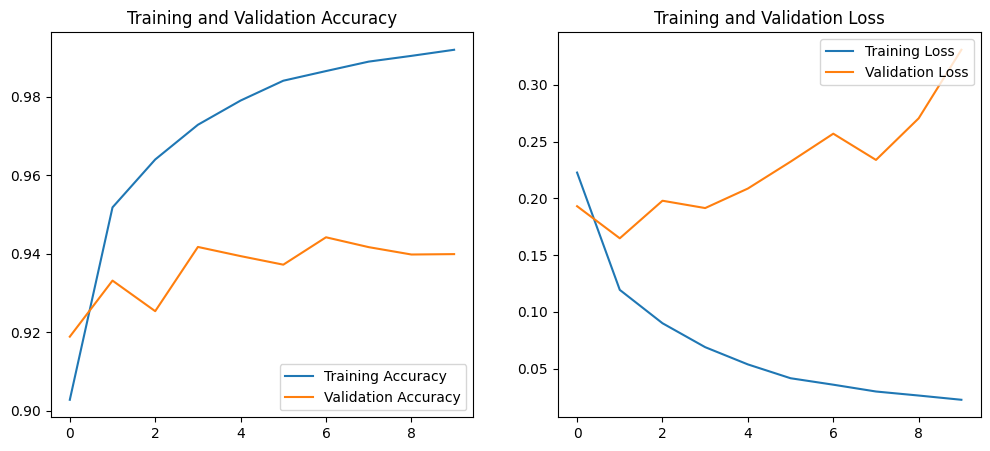

In [ ]:
def plot_training_history(history):
    acc = [h for h in history['train_acc']]
    val_acc = [h for h in history['val_acc']]
    loss = [h for h in history['train_loss']]
    val_loss = [h for h in history['val_loss']]

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

if 'history' in locals():
    plot_training_history(history)


### 6.1 Final Evaluation on Test Set

Now we use the unseen test set to get our final, unbiased metrics.


--- Classification Report ---
              precision    recall  f1-score   support

        Fake       0.89      0.92      0.91      5492
        Real       0.92      0.89      0.90      5413

    accuracy                           0.91     10905
   macro avg       0.91      0.91      0.91     10905
weighted avg       0.91      0.91      0.91     10905


--- Confusion Matrix ---


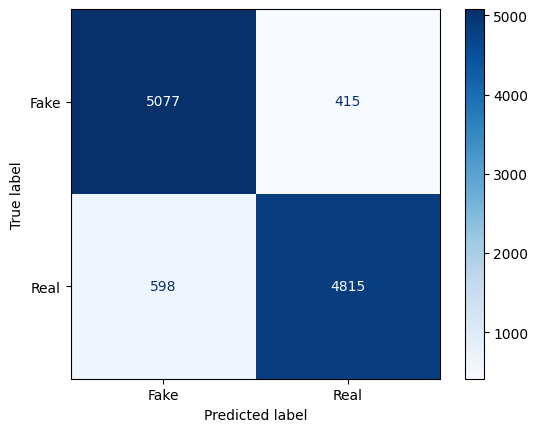

In [ ]:
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds).flatten()

if 'dataloaders' in locals() and 'model' in locals():
    y_true, y_pred = get_predictions(model, dataloaders['test'])

    print("\n--- Classification Report ---")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASS_NAMES)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

else:
    print("Skipping evaluation because data or model is not available.")